Name: Muhammad Osama     
Student Number: 1288056

# Human vs AI Text Classification

### Dataset
The project which i have worked on is Human vs AI Text Classification. The dataset contains text of 2 types Human Written and AI Generated. And the goal of my project is to efficiently differentiate between AI and Human written text. It has total 5000 samples (2500 for each class), the datset contains 2 columns text and labels. Label 0 is representing Human Written text while label 1 means the text is generated by AI.

Link to dataset: https://www.kaggle.com/datasets/aknjit/human-vs-ai-text-classification-dataset/data


In [23]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Loading the dataset
df = pd.read_csv("AIHumanData.csv") 

# Checking first 5 rows of dataset
print(df.head())

# Checking for null values
print(df.isnull().sum())

print(df.shape)

                                                text  label
0  Exercise plays a crucial role in supporting me...      1
1  Renewable energy helps fight climate change by...      1
2  A futuristic smart city is a vibrant, intercon...      1
3  Healthy eating habits are especially important...      1
4  Machine learning is transforming healthcare by...      1
text     0
label    0
dtype: int64
(5000, 2)


After loading the dataset checking for null values and printing the shape of dataset. I have also printed the first few rows of dataset to see if everything was correct.

### Visualization Techniques

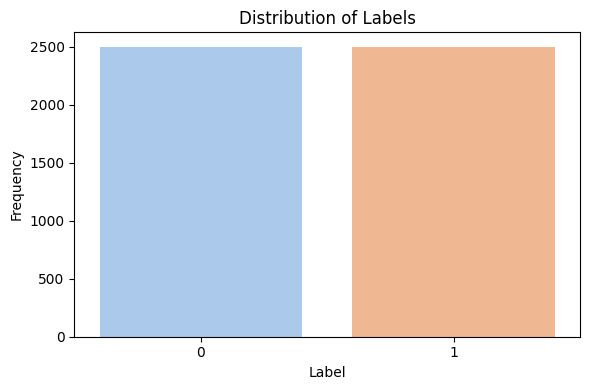

In [15]:
# Label distribution across the dataset
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, hue='label', palette='pastel', legend=False)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

The bar graph is showing us the distribution of label across the dataset. In other words we can say how much text does each class have. Here, Human Generated Text is (0) and AI generated text is (1). This is important becasue this shows the balance of dataset here we  have balanced dataset with each class have 2500 samples.

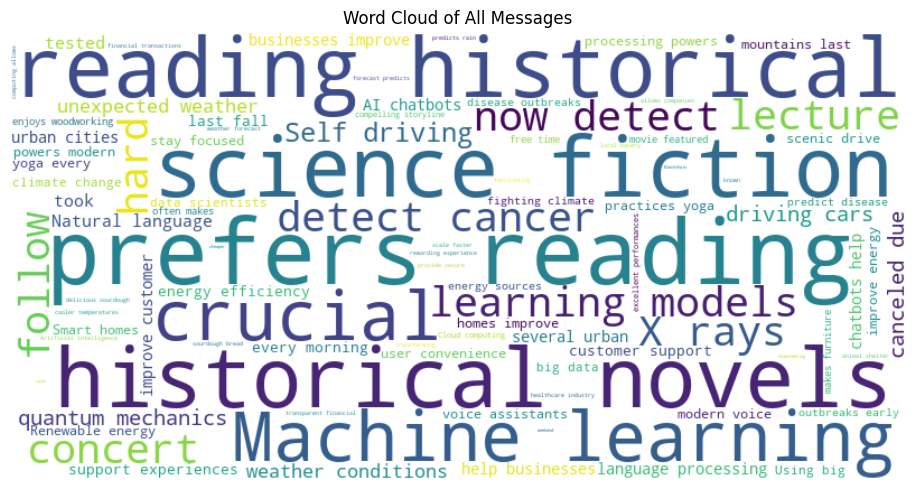

In [16]:
# Word Cloud technique for visualizing data
text_all = ' '.join(df['text'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_all)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Messages')
plt.tight_layout()
plt.show()

Word cloud is a powerful visualization that highlights the most frequently used words in our dataset. The larger the word appears the more often it shows up across your texts. It is important to know the dominant words in our dataset and guides feature engineering. It can help us identify words worth keeping or removing, if odd or meaningless words were big like "http" or punctuation mark.

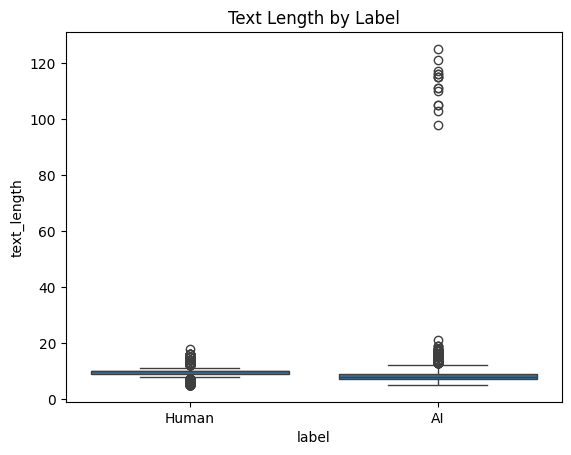

In [17]:
df["text_length"] = df["text"].apply(lambda x: len(x.split()))
sns.boxplot(x="label", y="text_length", data=df)
plt.xticks([0, 1], ["Human", "AI"])
plt.title("Text Length by Label")
plt.show()

The plot is representing a comparison of word count distributions between the "Human" and "AI" generated texts. The thing to take from this is that while the typical length for both is similar and short, the AI-generated texts have a much higher number of and more extreme outliers in terms of length.

### Data Preprocessing with SpaCy

In [24]:
# Load SpaCy model
nlp = spacy.load("en_core_web_lg")

# Preprocessing function
def preprocess_text(text):
    doc = nlp(text)
    tokens = [
        token.lemma_.lower() for token in doc
        if not token.is_stop and not token.is_punct and token.is_alpha
    ]
    return " ".join(tokens)

# Apply preprocessing
df["clean_text"] = df["text"].apply(preprocess_text)

# Splitting the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"], df["label"], test_size=0.2, random_state=42)

In [25]:
# Human generated cleaned samples
df[df["label"] == 0][["text", "clean_text"]].sample(3)

,text,clean_text
913,Hieroglyphics recorded the lives of pharaohs.,hieroglyphic record life pharaoh
301,I love waking up to the smell of fresh coffee ...,love wake smell fresh coffee lazy sunday
3123,She prefers reading historical novels over sci...,prefer read historical novel science fiction


In [26]:
# AI generated cleaned samples
df[df["label"] == 1][["text", "clean_text"]].sample(3)

,text,clean_text
2590,Self-driving cars are being tested in several ...,self drive car test urban city
2508,Natural language processing powers modern voic...,natural language processing power modern voice...
1803,Natural language processing powers modern voic...,natural language processing power modern voice...


For data cleaning I am using spacy pipeline to lemmatize input text to provide cleaner picture for ml models. I have lowercases the words, removed stop words and punctuation and then lemmatized the text. Lemmatization is important here as it converts each word to it root form, it ensures our model sees different forms of the same word as one which reduces vocabulary size and improves generalization.
Then I have shown some samples of cleaned text for both type of labels.
I have also split the data in test and train for further for our models. 

### Model Selection

### SpaCy TextCategorizer

#### Training the Model

In [27]:
# Model Spacy categorizer
print("\nSpaCy TextCategorizer ")

# Converting to Spacy DocBin
train_data = list(zip(X_train, [{"cats": {"AI": bool(lbl), "Human": not bool(lbl)}} for lbl in y_train]))
test_data = list(zip(X_test, [{"cats": {"AI": bool(lbl), "Human": not bool(lbl)}} for lbl in y_test]))

# Different Hyperparameters for tuning
spacy_configs = [
    {"width": 64, "dropout": 0.3},
    {"width": 64, "dropout": 0.5},
    {"width": 128, "dropout": 0.3},
    {"width": 128, "dropout": 0.5}
]

spacy_results = []

# Training the model
for config in spacy_configs:
    print(f"\nTraining SpaCy config: {config}")
    nlp_spacy = spacy.blank("en")
    textcat = nlp_spacy.add_pipe("textcat")
    textcat.add_label("AI")
    textcat.add_label("Human")

    optimizer = nlp_spacy.initialize()

    for epoch in range(5):
        losses = {}
        for text, annotations in train_data:
            doc = nlp_spacy.make_doc(text)
            example = spacy.training.Example.from_dict(doc, annotations)
            nlp_spacy.update([example], drop=config["dropout"], losses=losses)
        print(f"Epoch {epoch+1} - Losses: {losses}")

    # Evaluating the model for best hyperparameters
    y_pred = []
    for text in X_test:
        doc = nlp_spacy(text)
        y_pred.append(1 if doc.cats["AI"] > doc.cats["Human"] else 0)

    metrics = {
        "config": config,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred)
    }
    spacy_results.append(metrics)


=== SpaCy TextCategorizer ===

Training SpaCy config: {'width': 64, 'dropout': 0.3}
Epoch 1 - Losses: {'textcat': 76.59439824969164}
Epoch 2 - Losses: {'textcat': 12.791310964345985}
Epoch 3 - Losses: {'textcat': 6.160339361096011}
Epoch 4 - Losses: {'textcat': 1.8060167630308506}
Epoch 5 - Losses: {'textcat': 7.510038983239763}

Training SpaCy config: {'width': 64, 'dropout': 0.5}
Epoch 1 - Losses: {'textcat': 128.76121921751925}
Epoch 2 - Losses: {'textcat': 16.176007251665563}
Epoch 3 - Losses: {'textcat': 14.867521454003894}
Epoch 4 - Losses: {'textcat': 6.221689905630755}
Epoch 5 - Losses: {'textcat': 0.9841785656084122}

Training SpaCy config: {'width': 128, 'dropout': 0.3}
Epoch 1 - Losses: {'textcat': 75.23060197915346}
Epoch 2 - Losses: {'textcat': 5.324989243935417}
Epoch 3 - Losses: {'textcat': 10.528610656547833}
Epoch 4 - Losses: {'textcat': 4.199292019980318}
Epoch 5 - Losses: {'textcat': 4.354732599291541}

Training SpaCy config: {'width': 128, 'dropout': 0.5}
Epoch 1 -

Her I am describing the training and evaluation of a spacy text classification model designed to differentiate between human-written and AI-generated text. The process involves a hyperparameter tuning loop where four different configurations of the model are tested, varying the width (64 and 128) and dropout (0.3 and 0.5) values. For each configuration, the model is trained over five epochs, with the decreasing loss values indicating that the model is learning. After training, each models performance is evaluated on a separate test set using standard metrics like accuracy, precision, and recall. And further I will save the best hyperparameter which provide us the best value for F1 score.

#### Evaluation on Best Hyperparameter

In [28]:
from sklearn.metrics import classification_report

# Final Evaluation on best hyperparameters
best_spacy = max(spacy_results, key=lambda x: x["f1"])
print(f"\nBest SpaCy Config: {best_spacy['config']} with F1 = {best_spacy['f1']:.4f}")

# Retrain Spacy with best config we found for the hyperparameters
nlp_best_spacy = spacy.blank("en")
textcat = nlp_best_spacy.add_pipe("textcat")
textcat.add_label("AI")
textcat.add_label("Human")
optimizer = nlp_best_spacy.initialize()

for epoch in range(5):
    losses = {}
    for text, annotations in train_data:
        doc = nlp_best_spacy.make_doc(text)
        example = spacy.training.Example.from_dict(doc, annotations)
        nlp_best_spacy.update([example], drop=best_spacy['config']["dropout"], losses=losses)
    print(f"Epoch {epoch+1} - Losses: {losses}")

# Prediction on test data
y_pred_spacy_best = []
for text in X_test:
    doc = nlp_best_spacy(text)
    y_pred_spacy_best.append(1 if doc.cats["AI"] > doc.cats["Human"] else 0)


Best SpaCy Config: {'width': 64, 'dropout': 0.5} with F1 = 0.9920
Epoch 1 - Losses: {'textcat': 127.34166707810492}
Epoch 2 - Losses: {'textcat': 15.528273612766577}
Epoch 3 - Losses: {'textcat': 8.721861890758321}
Epoch 4 - Losses: {'textcat': 10.799237292966804}
Epoch 5 - Losses: {'textcat': 4.788799550101363}


In this section using above we came to know the best hyperparameters for our model based on training set, now here I am retraining the model on best hyperparametrs and using that model on test data. 

#### Visualizing the Results

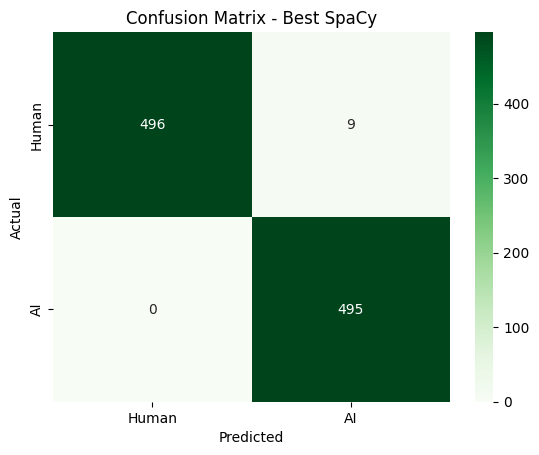


Classification Report (SpaCy):

              precision    recall  f1-score   support

       Human       1.00      0.98      0.99       505
          AI       0.98      1.00      0.99       495

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000


Sample Predictions (SpaCy):
                                                    Text  Actual  Predicted
3707  movie feature compelling storyline excellent p...       0          0
828       great explorer map unknown region century ago       0          0
2664                    take scenic drive mountain fall       0          0
1047                    take scenic drive mountain fall       0          0
3197                     self drive car test urban city       1          1


In [29]:
# Confusion Matrix
cm_spacy = confusion_matrix(y_test, y_pred_spacy_best)
sns.heatmap(cm_spacy, annot=True, fmt='d', cmap='Greens',
            xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
plt.title("Confusion Matrix - Best SpaCy")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\nClassification Report (SpaCy):\n")
print(classification_report(y_test, y_pred_spacy_best, target_names=["Human", "AI"]))

# Sample Predictions
sample_df_spacy = pd.DataFrame({"Text": X_test.sample(5, random_state=42)})
sample_df_spacy["Actual"] = y_test.loc[sample_df_spacy.index]
sample_df_spacy["Predicted"] = [
    1 if nlp_best_spacy(text).cats["AI"] > nlp_best_spacy(text).cats["Human"] else 0
    for text in sample_df_spacy["Text"]
]
print("\nSample Predictions (SpaCy):\n", sample_df_spacy)

Here I have visualized the prediction of our model. First is the confusion matrix it shows the actual vs predicted labels we can see our model did a great job. Out of all the samples for each class it classified only 9 as wrong. Those 9 were actual human written and our model predicted as AI generated.
Next is classification report where we can see the recall precision and accuracy of our model. And lastly i have printed some samples fo Actual vs Predicted text.

### Random Forest Classifier

#### Training the Model

In [34]:
# Model RandomForestClassifier
print("\nRandomForestClassifier")

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Trying different hyperparameters
rf_configs = [
    {"n_estimators": 100, "max_depth": 10},
    {"n_estimators": 100, "max_depth": 20},
    {"n_estimators": 200, "max_depth": 10},
    {"n_estimators": 200, "max_depth": 20}
]

rf_results = []

# Training the model
for config in rf_configs:
    print(f"\nTraining RF config: {config}")
    rf = RandomForestClassifier(n_estimators=config["n_estimators"], max_depth=config["max_depth"], random_state=42)
    rf.fit(X_train_vec, y_train)
    y_pred = rf.predict(X_test_vec)

    metrics = {
        "config": config,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred)
    }
    rf_results.append(metrics)


RandomForestClassifier

Training RF config: {'n_estimators': 100, 'max_depth': 10}

Training RF config: {'n_estimators': 100, 'max_depth': 20}

Training RF config: {'n_estimators': 200, 'max_depth': 10}

Training RF config: {'n_estimators': 200, 'max_depth': 20}


In this section have my 2nd model which is a Rondom Forrest Classifier. The method begins with converting text data into numerical feature vectors using a CountVectorizer. Subsequently, a loop is initiated to iterate through four different hyperparameter configurations, varying the n_estimators (number of trees) and max_depth of the forest. For each configuration, a new classifier is trained on the vectorized data, predictions are made on a test set, and the model's performance is evaluated using key metrics such as accuracy, precision, recall, and F1-score. The final results are stored, allowing for a direct comparison of the configurations to determine which set of hyperparameters yields the most effective Random Forest model for the given problem.

#### Evaluation on Best Hyperparameter

In [35]:
# Final Evaluation RandomForest Model
best_rf = max(rf_results, key=lambda x: x["f1"])
print(f"\nBest RandomForest Config: {best_rf['config']} with F1 = {best_rf['f1']:.4f}")

# Retrain the model with best hyperparameters
rf_best = RandomForestClassifier(**best_rf["config"], random_state=42)
rf_best.fit(X_train_vec, y_train)
y_pred_rf_best = rf_best.predict(X_test_vec)


Best RandomForest Config: {'n_estimators': 200, 'max_depth': 20} with F1 = 0.9730


Here I have prionted my best hyperparameters and retrained my model on that and then made predictions on the test data.

#### Visualizing the Results

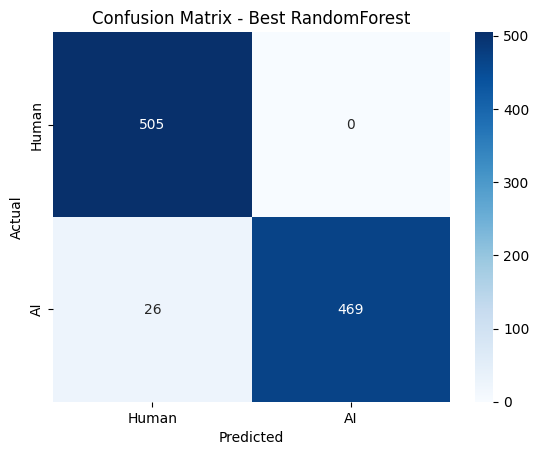


Classification Report (RandomForest):

              precision    recall  f1-score   support

       Human       0.95      1.00      0.97       505
          AI       1.00      0.95      0.97       495

    accuracy                           0.97      1000
   macro avg       0.98      0.97      0.97      1000
weighted avg       0.98      0.97      0.97      1000


Sample Predictions (RandomForest):
                                                    Text  Actual  Predicted
3707  movie feature compelling storyline excellent p...       0          0
828       great explorer map unknown region century ago       0          0
2664                    take scenic drive mountain fall       0          0
1047                    take scenic drive mountain fall       0          0
3197                     self drive car test urban city       1          1


In [36]:
# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf_best)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
plt.title("Confusion Matrix - Best RandomForest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\nClassification Report (RandomForest):\n")
print(classification_report(y_test, y_pred_rf_best, target_names=["Human", "AI"]))

# Sample Predictions
sample_df_rf = pd.DataFrame({"Text": X_test.sample(5, random_state=42)})
sample_df_rf["Actual"] = y_test.loc[sample_df_rf.index]
sample_df_rf["Predicted"] = rf_best.predict(vectorizer.transform(sample_df_rf["Text"]))
print("\nSample Predictions (RandomForest):\n", sample_df_rf)

Here I have visualized the prediction of our model. First is the confusion matrix it shows the actual vs predicted labels we can see our model did a great job. Out of all the samples for each class it classified only 26 as wrong. Those 26 were actual AI generated and our model predicted as Human written. Next is classification report where we can see the recall precision and accuracy of our model. And lastly i have printed some samples for Actual vs Predicted text.

### Comparison of Both Models


Model Comparison:
           Model  Accuracy  Precision    Recall  F1-Score
0         SpaCy     0.991   0.982143  1.000000  0.990991
1  RandomForest     0.974   1.000000  0.947475  0.973029


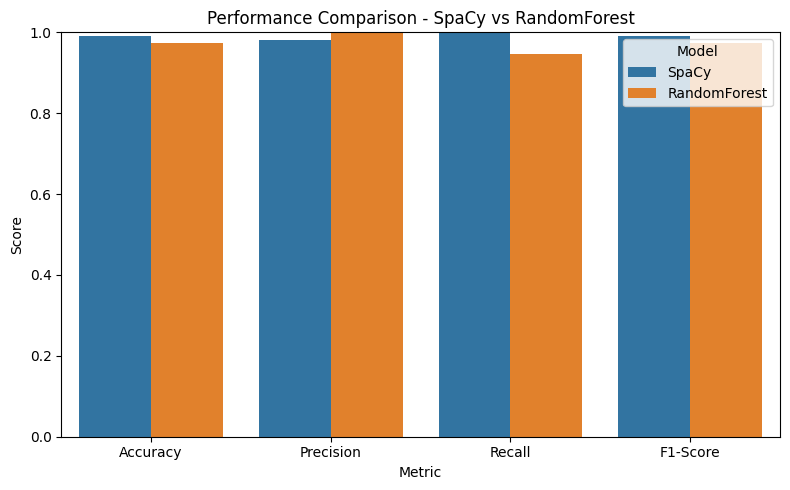

In [37]:
# Comparison between both Models
comparison_df = pd.DataFrame({
    "Model": ["SpaCy", "RandomForest"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_spacy_best),
        accuracy_score(y_test, y_pred_rf_best)
    ],
    "Precision": [
        precision_score(y_test, y_pred_spacy_best),
        precision_score(y_test, y_pred_rf_best)
    ],
    "Recall": [
        recall_score(y_test, y_pred_spacy_best),
        recall_score(y_test, y_pred_rf_best)
    ],
    "F1-Score": [
        f1_score(y_test, y_pred_spacy_best),
        f1_score(y_test, y_pred_rf_best)
    ]
})

print("\nModel Comparison:\n", comparison_df)

# Bar Plot
comparison_df_melted = comparison_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
plt.figure(figsize=(8,5))
sns.barplot(data=comparison_df_melted, x="Metric", y="Score", hue="Model")
plt.title("Performance Comparison - SpaCy vs RandomForest")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

Here I have made a comparison of both the models that I have used on our data. From our results we can conclude how well both models have performed however Spacy textcategorizer nearly outperformed our Random Forrest Classifier. Overall if we talk about accuracy Spacy model acheived as the nearly superior choice, showcasing a higher overall accuracy 99.1 percent and a perfect recall score of 100 percent. While the RandomForest model achieves  perfect precision 100 percent, its lower recall and slightly lower F1-Score 97.3 percent indicate it missed some positive instances that the Spacy model successfully identified. Therefore, for this specific problem, the SpaCy model provides a more balanced and robust performance, making it the preferred model for deployment.

SpaCy uses embeddings and a small neural network internally, which allows capturing semantic relationships between words beyond simple frequency counts. RandomForest works with sparse vectors and cannot capture context, it depends solely on the bag-of-words representation. On short or simple texts, both models performed comparably. On longer or more complex texts, SpaCy may generalize better.

Talking about computaional cost Spacy is more computationally intensive during training due to neural network updates, especially with higher widths or larger datasets. Whereas, randomForest is extremely fast to train and evaluate on small datasets, with minimal hyperparameter tuning required. Prediction time for both models is fast on small datasets, but for large-scale deployment, RandomForest may be preferable unless semantic understanding is critical.

Based on the evaluation of both Spacy TextCategorizer and Random Forest Classifier, the choice of model depends on the specific requirements of the task and dataset characteristics. RandomForest is highly suitable for small to moderately sized datasets where training speed, computational efficiency, and model interpretability are priorities. It performs well using simple bag-of-words features, making it reliable for straightforward text classification tasks. In contrast, SpaCy’s TextCategorizer excels at capturing semantic and contextual relationships within text, which can improve generalization on longer or more complex datasets. However, this comes at a higher computational cost and longer training time. Overall, RandomForest is recommended for efficiency and simplicity, whereas SpaCy is preferred when nuanced textual understanding and semantic richness are important. For optimal performance, combining both models in an ensemble could leverage the strengths of each approach.

For this text classification task, both models performed exceptionally well. RandomForest achieved F1 = 0.9730 with n_estimators = 200 and max_depth = 20, showing that more trees and deeper splits improved pattern capture. SpaCy reached F1 = 0.9920 with width = 64 and dropout = 0.5, indicating that a moderately sized network with higher regularization optimally learned spatterns. Thus, hyperparameter tuning was key, RandomForest excels with larger, deeper trees for efficiency, while SpaCy benefits from balanced network width and dropout for maximum accuracy.